# **Breast Cancer - Comparative Analysis (Explainability with GradCAM) - MobileNetV2**

Dataset (Train and Validation) link: https://web.inf.ufpr.br/vri/databases/breast-cancer-histopathological-database-breakhis/

Annotated Dataset (Test) link: https://figshare.com/articles/dataset/BreCaHAD_A_Dataset_for_Breast_Cancer_Histopathological_Annotation_and_Diagnosis/7379186?file=13646369

Note: The test set only contains malignant class images.

The following project will focus on finding the architecture (used with GradCAM) with the best explainability efficiency. The proposed architectures for this experiment are:
* EfficientNetB0
* VisionTrasformer
* DenseNet201
* NasNetLarge
* MobileNetV3Large/MobileNetV2

This notebook represents one of the five which will run experiments with images where the Visual Magnification factor is 400x - MobileNetV2.   

In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json

import os
import random
from random import random, randint, seed
import pickle
import pathlib
import warnings
import platform

import cv2 as cv
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.applications import densenet, MobileNetV3Large, efficientnet, nasnet, MobileNetV2
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
print("Python- Versão: ", platform.python_version())
print("TensorFLow - Versão: ",tf.__version__)

# Checar GPUs
if not tf.test.gpu_device_name():
    warnings.warn('GPU não encontrada.')
else:
    print(f'Dispositivo GPU padrão: {tf.test.gpu_device_name()}')
    print("Número de GPUs Disponíveis: ", len(tf.config.list_physical_devices('GPU')))


Python- Versão:  3.8.13
TensorFLow - Versão:  2.9.1
Dispositivo GPU padrão: /device:GPU:0
Número de GPUs Disponíveis:  1


In [3]:
for dirpath, dirnames, filenames in os.walk('SiDi_BreakHis400x_train_val/dataset'):
    if len(filenames)!=0:
        print(f'Existem {len(filenames)} imagens em  {dirpath}.')


Existem 1037 imagens em  SiDi_BreakHis400x_train_val/dataset\train_set\benign.
Existem 1037 imagens em  SiDi_BreakHis400x_train_val/dataset\train_set\malignant.
Existem 180 imagens em  SiDi_BreakHis400x_train_val/dataset\validation_set\benign.
Existem 180 imagens em  SiDi_BreakHis400x_train_val/dataset\validation_set\malignant.


In [4]:
train_dir = 'SiDi_BreakHis400x_train_val/dataset/train_set/'
val_dir = 'SiDi_BreakHis400x_train_val/dataset/validation_set/'
test_dir = 'SiDi_BreCaHAD_test/dataset'

# Especificações para o treinamento da rede
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
EPOCHS = 100

In [5]:
train_datagen = ImageDataGenerator(rescale=None)
valid_datagen = ImageDataGenerator(rescale=None)
test_datagen = ImageDataGenerator(rescale=None)

train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

val_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=BATCH_SIZE,  
                                               target_size=(224, 224), 
                                               class_mode="categorical")

Found 2074 images belonging to 2 classes.
Found 360 images belonging to 2 classes.
Found 159 images belonging to 2 classes.


In [6]:
''' # include_top=False retira a camada do topo, ou seja, a camada densa do modelo original
basemodel = MobileNetV2(include_top=False,
                                 weights='imagenet',
                                 input_shape=IMG_SHAPE,
                                 pooling='max')
# Note que a última camada de convolução termina com a operação de GlobalMaxPooling2D(dependendo do modelo poderia ser a Flatten)
# Assim, podemos adicionar a saída do baseModel diretamente na camada densa
# basemodel.summary()'''

In [10]:
# Criar a arquitetura da camada densa do modelo para o Fine Tuning
inputs = Input(shape=IMG_SHAPE)

xi = tf.cast(inputs, tf.float32)
xi = tf.keras.applications.mobilenet_v2.preprocess_input(xi)

basemodel = MobileNetV2(include_top=False,
                        weights='imagenet',
                        input_tensor = xi,
                        input_shape=IMG_SHAPE,
                        pooling='max')

'''x = Dense(256, activation="relu")(basemodel.output)
x = Dropout(0.2)(x)'''

x = BatchNormalization()(basemodel.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)

x = BatchNormalization()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.2)(x)

'''x = BatchNormalization()(x)
x = Dense(32, activation="relu")(x)
x = Dropout(0.2)(x)
'''

outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)

In [11]:
#model.summary()

## Fine Tuning - Fase 1 (warm up) -> treina apenas a camada densa

In [9]:
# Congela as camadas do modelo base (as camadas de convolução não serão treinadas novamente)
for layer in basemodel.layers:
    layer.trainable = False  

In [12]:
base_learning_rate = 0.0001
opt = Adam(learning_rate=base_learning_rate)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [13]:
# Early Stopping do trinamento
early_stop = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_MobileNetV2_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks = [early_stop, model_ckpt]

In [14]:
# Fase 1 - treina apenas com algumas épocas (40% do total)
initial_epochs = int(EPOCHS*0.4)
history = model.fit(train_data,
                    epochs=initial_epochs,
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks)

Epoch 1/40
65/65 [==============================] - 38s 423ms/step - loss: 0.5048 - accuracy: 0.7618 - val_loss: 0.7327 - val_accuracy: 0.6528
Epoch 2/40
65/65 [==============================] - 24s 361ms/step - loss: 0.2781 - accuracy: 0.8693 - val_loss: 0.6292 - val_accuracy: 0.6889
Epoch 3/40
65/65 [==============================] - 23s 351ms/step - loss: 0.1848 - accuracy: 0.9248 - val_loss: 0.7091 - val_accuracy: 0.6778
Epoch 4/40
65/65 [==============================] - 23s 345ms/step - loss: 0.1172 - accuracy: 0.9585 - val_loss: 0.8914 - val_accuracy: 0.6472
Epoch 5/40
65/65 [==============================] - 23s 346ms/step - loss: 0.0805 - accuracy: 0.9788 - val_loss: 0.9355 - val_accuracy: 0.6583
Epoch 6/40
65/65 [==============================] - 23s 348ms/step - loss: 0.0452 - accuracy: 0.9899 - val_loss: 0.8529 - val_accuracy: 0.7139
Epoch 7/40
65/65 [==============================] - 23s 353ms/step - loss: 0.0484 - accuracy: 0.9851 - val_loss: 0.9805 - val_accuracy: 0.6639

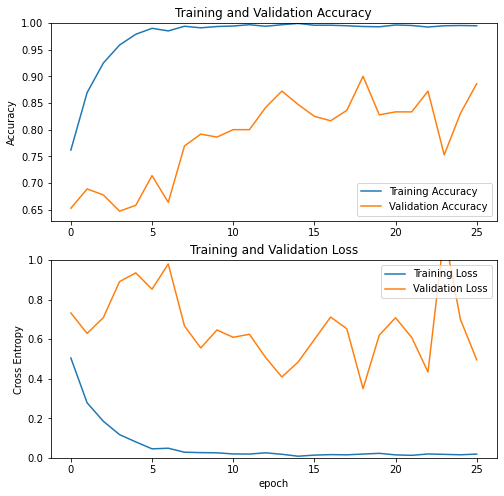

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Fine Tuning - Fase 2 -> treina todo o modelo do fine tuning - descongela as camadas de convolução

In [16]:
print("Número de camadas do modelo base: ", len(basemodel.layers))

Número de camadas do modelo base:  158


In [17]:
# Descongelar as 30% camadas finais e que não seja do tipo BatchNormalization do modelo base
# Note que vpcê pode adicionar mais camadas se o modelo não for muito grande
count = 0
for layer in basemodel.layers[-int(len(basemodel.layers)*0.3):]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

In [18]:
# É necessário diminuir a base_learning_rate para que o modelo não tenha convergência muito rápida
# pois se trata d eum modelo grande
opt = Adam(learning_rate=base_learning_rate/10)
# binary -> binary_crossentropy; categorical -> categorical_crossentropy
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [19]:
# EarlyStopping do trinamento
early_stop2 = keras.callbacks.EarlyStopping(
    monitor = 'val_loss', 
    min_delta=0.001, 
    patience=7
)

model_ckpt2 = keras.callbacks.ModelCheckpoint(
    filepath='callbacks/melhor_modelo_MobileNetV2_ft.hdf5', 
    monitor='val_loss', 
    save_best_only=True
)

callbacks2 = [early_stop2, model_ckpt2]

In [20]:
# Fase 2 - treina apenas com a quantidade de épocas que faltam (60% finais)
# Note que iniciará de initial_epoch=history.epoch[-1]
history_fine = model.fit(train_data,
                    epochs=EPOCHS,
                    initial_epoch=history.epoch[-1],
                    steps_per_epoch=len(train_data),
                    validation_data=val_data,
                    validation_steps=len(val_data), 
                    callbacks=callbacks2)

Epoch 26/100
65/65 [==============================] - 31s 413ms/step - loss: 0.0085 - accuracy: 0.9981 - val_loss: 0.4762 - val_accuracy: 0.8861
Epoch 27/100
65/65 [==============================] - 38s 581ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.4380 - val_accuracy: 0.8944
Epoch 28/100
65/65 [==============================] - 26s 390ms/step - loss: 0.0065 - accuracy: 0.9981 - val_loss: 0.4180 - val_accuracy: 0.9028
Epoch 29/100
65/65 [==============================] - 24s 367ms/step - loss: 0.0058 - accuracy: 0.9986 - val_loss: 0.3996 - val_accuracy: 0.9028
Epoch 30/100
65/65 [==============================] - 24s 370ms/step - loss: 0.0049 - accuracy: 0.9995 - val_loss: 0.3797 - val_accuracy: 0.9111
Epoch 31/100
65/65 [==============================] - 24s 363ms/step - loss: 0.0042 - accuracy: 1.0000 - val_loss: 0.3551 - val_accuracy: 0.9167
Epoch 32/100
65/65 [==============================] - 38s 585ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.3281 - val_ac

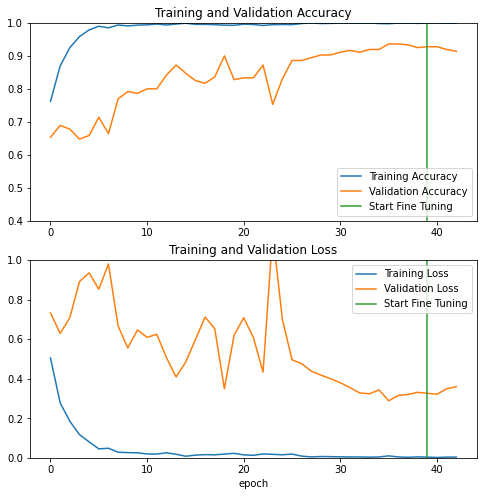

In [21]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:
# Avaliação usando os dados de testes
loss, acc = model.evaluate(test_data)
print ("Test accuracy: %.3f" % acc)
print ("Test loss: %.3f" % loss)

5/5 [==============================] - 8s 2s/step - loss: 0.0407 - accuracy: 0.9874
Test accuracy: 0.987
Test loss: 0.041


In [23]:
model.save("Models_Save/1NF_Categorical_SiDi_Save_Model_MobileNetV2")

INFO:tensorflow:Assets written to: Models_Save/1NF_Categorical_SiDi_Save_Model_MobileNetV2\assets


INFO:tensorflow:Assets written to: Models_Save/1NF_Categorical_SiDi_Save_Model_MobileNetV2\assets


# GRADCAM

In [24]:
test_dir = 'SiDi_BreCaHAD_test/dataset'
data_dir_test = pathlib.Path(test_dir)

class_names = np.array(sorted([item.name for item in data_dir_test.glob('*')]))
print(f'Types: {class_names}')

Types: ['benign' 'malignant']


In [36]:
# Carrega o modelo
model = load_model("Models_Save/1NF_Categorical_SiDi_Save_Model_MobileNetV2")

In [44]:
last_conv_layer_name = list(filter(lambda x: isinstance(x, keras.layers.Conv2D), model.layers))[-1].name
print(last_conv_layer_name) 

Conv_1


In [45]:
def get_img_array(img_path, size):

    # `img` is a PIL image of size 299x299
    img = tf.keras.utils.load_img(img_path, target_size=size)
    
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = tf.keras.utils.img_to_array(img)
    
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array



def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model([model.inputs],[model.get_layer(last_conv_layer_name).output, model.output])
           

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, predictions = grad_model(img_array)
        predictions = tf.squeeze(predictions)
        if pred_index is None:
            pred_index = tf.argmax(predictions)
        class_channel = predictions[pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    
    return heatmap.numpy()

In [46]:
# Prepare image
def generate_heatmap(img_path):
    img_array = get_img_array(img_path, size=(224,224))

    # Remove last layer's softmax
#     model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    top_pred_index = tf.argmax(preds[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    heat_test = heatmap.copy()

    # Display heatmap
#     print(heatmap)
    #plt.matshow(heatmap)
    #plt.show()
    
    return heatmap, class_names[top_pred_index], preds[0][top_pred_index]

In [47]:
def save_and_display_gradcam(img_path, heatmap, alpha=0.9, pred=None): #cam_path="saved/teste_1.jpg"
    
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # only for generating images
    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)
    
    # generating mask
#     jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_RGB2GRAY)
    _, _, jet_heatmap = cv.split(jet_heatmap)
    
    # Otsu's thresholding
    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


    # Display Grad CAM
#     plt.imshow(superimposed_img) # comentar quando for gerar o dataframe
    
    return thresh

# Gerar dataset

In [48]:
def loading_json(filen='SiDi_BreCaHAD_test/groundTruth/'):
    tumor_cells = {}
    annot_points = {}
    
    for root, dirs, items in os.walk(filen):
        for i, item in enumerate(items):
            # Opening JSON file
            f = open(filen+item)
            # returns JSON object as 
            # a dictionary
            data = json.load(f)
            
            # adding values to dictionary
            tumor_cells[item.split('.')[0]] = len(data['tumor'])
            
            # creating list to get the annotations coordinates
            x_y = []
            for j, points in enumerate(data['tumor']):
                # list to get the coordinates of one annotation
                values_i_j = []
                
                # the values are multiplied by the image resolution
                values_i_j.append(int(points['x']*1360))
                values_i_j.append(int(points['y']*1024))
                
                # adding the coordinates to the list of one case
                x_y.append(values_i_j)
            
            # adding corresponding annotations to the respective case
            annot_points[item.split('.')[0]] = x_y

            # Closing file
            f.close()
            
    return tumor_cells, annot_points

In [49]:
def getting_probs(filen='SiDi_BreCaHAD_test/dataset/malignant/'):
    # loading test images
    probs = []
    classes = []
    masks = []
    for root, dirs, items in os.walk(filen):
        for item in items:
            heatmap, class_, prob = generate_heatmap(filen+item)
            mask = save_and_display_gradcam(filen+item, heatmap, pred=class_)
            probs.append(round(prob*100,2))
            classes.append(class_)
            masks.append(mask)
            

    return classes, masks, probs

In [50]:
def checking_points(annot_points, lst_heatmaps):
    
    # list to check the correct values
    correct_values = []
    i = 0
    
    for k, v in annot_points.items():
        got_it_right = 0
        mask_matrix = lst_heatmaps[i]
        
        for a, b in enumerate(v):
            if mask_matrix[b[1]][b[0]] > 0:
                got_it_right += 1
        # adding the correct correspondences to the list      
        correct_values.append(got_it_right)
        i += 1
        
    return correct_values

In [51]:
def generating_dataset():
    
    tumor_cells, annot_points = loading_json()
    lst_classes, lst_heatmaps, lst_probs = getting_probs()
#     lst_tumors = interpretability(types=lst_classes, hmaps=lst_heatmaps)
    lst_tumors = checking_points(annot_points, lst_heatmaps)
    tumor_region = []
    accuracy = []
    
    # tumors found
    tumor_cells_values = list(tumor_cells.values())
    
    for i, qtd in enumerate(lst_tumors):
        if lst_classes[i] == 'benign':
            tumor_region.append(0)
            accuracy.append(0)
            
        else:
            tumor_region.append(round((qtd/tumor_cells_values[i])*100, 2))
            
    
    dataframe = pd.DataFrame(data=[tumor_cells.keys(), tumor_cells.values(), lst_classes, lst_probs,
                                  lst_tumors, tumor_region],
                             index=['Case', 'Total Tumor Cells', 'Pred. Type', 'Probability (%)',
                                     'Tumors Found' ,'Interpret. Region Accuracy (%)']).transpose()
    
    return dataframe

In [52]:
df = generating_dataset()

1/1 [==============================] - 0s 10ms/step


1/1 [==============================] - 0s 19ms/step


In [64]:
df.head(20)

,Case,Total Tumor Cells,Pred. Type,Probability (%),Tumors Found,Interpret. Region Accuracy (%)
0,Case_1-01,140,malignant,96.99,94,67.14
1,Case_1-02,153,malignant,99.05,32,20.92
2,Case_1-03,135,malignant,99.92,24,17.78
3,Case_1-04,103,malignant,100.0,29,28.16
4,Case_1-05,126,malignant,100.0,34,26.98
5,Case_1-06,176,malignant,99.97,59,33.52
6,Case_1-07,196,malignant,92.5,118,60.2
7,Case_1-08,116,malignant,99.87,65,56.03
8,Case_10-01,162,malignant,97.44,14,8.64
9,Case_10-02,139,malignant,97.62,60,43.17


In [54]:
len(df[(df['Pred. Type'] == 'malignant') & (df['Interpret. Region Accuracy (%)'] != 0)].index)

157

In [55]:
# Interpretability

mean = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].mean()
stdd = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)'].std()
itp_model = round(mean, 2)
std_deviation = round(stdd, 2)

print(f'Acurácia de interpretabilidade (%): {itp_model} +/- {std_deviation}')

Acurácia de interpretabilidade (%): 43.07 +/- 17.89


In [56]:
accuracy = 100*(len(df[(df['Pred. Type'] == 'malignant')].index)/len(df.index))
print("Acurácia de Classificação (%): ",round(accuracy,1))

Acurácia de Classificação (%):  98.7


(array([ 5., 21., 28., 27., 35., 17., 18.,  2.,  2.,  2.]),
 array([5.7, 15.129999999999999, 24.56, 33.99, 43.42, 52.85, 62.28, 71.71,
        81.14, 90.57000000000001, 100.0], dtype=object),
 <BarContainer object of 10 artists>)

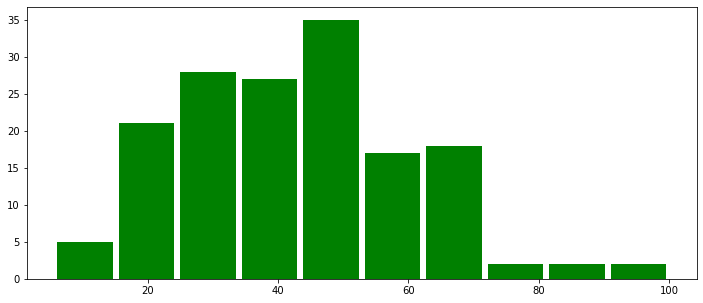

In [57]:
plt.figure(figsize=(12,5))
values = df[df['Pred. Type'] == 'malignant']['Interpret. Region Accuracy (%)']
plt.hist(x=values, bins=10, color='Green', rwidth=0.9)

### TESTE

In [58]:
def display_gradcam(img_path, heatmap, alpha=0.9, pred=None): #cam_path="saved/teste_1.jpg"
    
    # Load the original image
    img = tf.keras.utils.load_img(img_path)
    img = tf.keras.utils.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    if pred == 'malignant':
        jet = cm.get_cmap("jet")
    else:
        jet = cm.get_cmap("Greens")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.utils.array_to_img(jet_heatmap) #keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = np.array(jet_heatmap) # keras.preprocessing.image.img_to_array(jet_heatmap)
    
    # only for generating images
    # Superimpose the heatmap on original image
    superimposed_img = (jet_heatmap * alpha) + img
    superimposed_img = tf.keras.utils.array_to_img(superimposed_img)

    # Save the superimposed image
#     superimposed_img.save(cam_path)
    
    # generating mask
#     jet_heatmap = cv.cvtColor(jet_heatmap, cv.COLOR_RGB2GRAY)
    a, v, jet_heatmap = cv.split(jet_heatmap)
    
    plt.imshow(cv.cvtColor(a, cv.COLOR_RGB2BGR))
    plt.show()
    
    plt.imshow(cv.cvtColor(v, cv.COLOR_RGB2BGR))
    plt.show()
    
    plt.imshow(cv.cvtColor(jet_heatmap, cv.COLOR_RGB2BGR))
    plt.show()
    
    # Otsu's thresholding
    _, thresh = cv.threshold(jet_heatmap,0,255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)


    # Display Grad CAM
    plt.imshow(superimposed_img)
    plt.show()
    
    return thresh

In [65]:
case='Case_11-09'

In [66]:
IMG = 'SiDi_BreCaHAD_test/dataset/malignant/'+case+'.png'
PATH1 = 'SiDi_BreCaHAD_test/groundTruth_display/'+case+'.png'

1/1 [==============================] - 0s 18ms/step


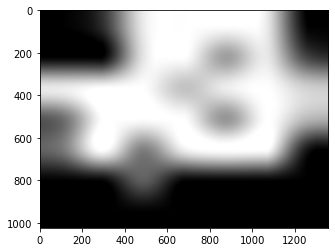

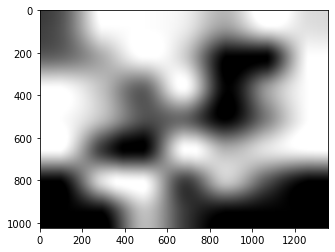

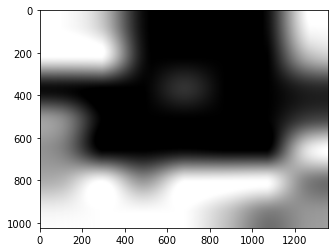

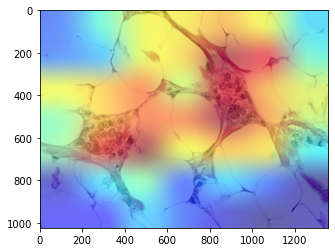

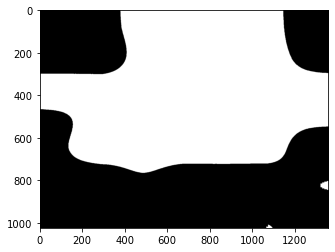

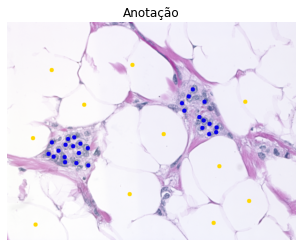

In [67]:
img = tf.keras.utils.load_img(PATH1)
img_orig = tf.keras.utils.load_img(IMG)
heatmap1, class_1, probs1 = generate_heatmap(IMG)

result = display_gradcam(img_path=IMG, heatmap=heatmap1, pred=class_1)
plt.imshow((result), cmap='gray')
plt.show()

plt.title('Anotação')
plt.axis(False)
plt.imshow(img)

In [68]:
print(result[600][600])

print(result[1000][600])

print(result[800][1200])

255
0
0


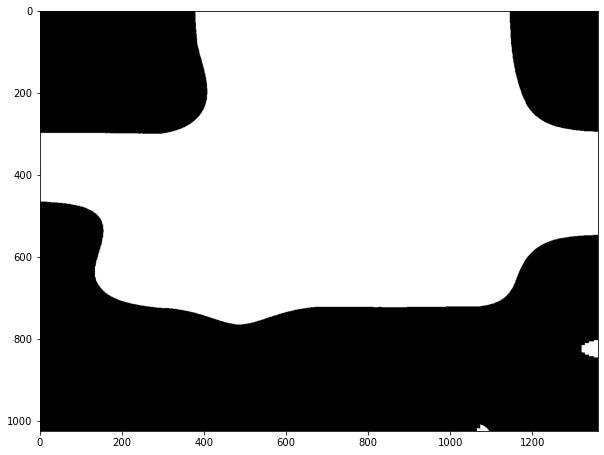

In [69]:
plt.figure(figsize=(10,10))

plt.imshow(result, cmap='gray')